<h1>Setup: selecting and labelling the training data</h1>

We know that the autonomous algorithms that work in 2-dimensional space and applied according to some gating strategy struggle to capture relevant cell populations in disease datasets where there is alot of variation. 

An alternative approach is taking a representative sample, labelling the cells in that sample according to our gating strategy with a traditional manual approach, and then using this labelled dataset to train a classifier. The theory here is that dispite the inter-sample variation, there exists biological signals (cell populations) that are shared across samples and are distinguishable in our high-dimensional expression data.

In this notebook I will, for each experiment, create training data, validation data, and label according to our standard gating strategy; that is I will identify the major cell subsets of interest and label cells by these subsets.

Training data is a difficult question, because what is a representative sample? To address this issue I will create two different sources of training data:
1. The training sample will be chosen by computing the euclidean norm of each pair of samples and choose the sample that is the minimum i.e. the most central sample in a shared euclidean space.
2. Cells will be sampled uniformally from each patient to create a concatenated 'global sample', containing cells from every patient. This should capture the variation from every patient.

The best performing method of training will be chosen based on weighted F1 score when compared to validation data.

In [2]:
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.supervised.cell_classifier import create_reference_sample
from immunova.flow.supervised.utilities import calculate_ref_sample_fast
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

In [3]:
# Load experiments
pdtexp = FCSExperiment.objects(experiment_id='PD_T_PDMCs').get()
pbtexp = FCSExperiment.objects(experiment_id='PD_T_PBMCs').get()
nexp = FCSExperiment.objects(experiment_id='PD_N_PDMCs').get()

<h2>Choosing the training data</h2>

<h3>The 'average' sample</h3>

Immunova has many utility functions. One of these selects the sample with the smallest average distance to all other samples in euclidean space; for every 2 samples i, j compute the Frobenius norm of the difference between their covariance matrics and then select the sample with the smallest average distance to all other samples. This is performed as described in Li et al paper (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5860171/)

There are two implementations in Immunova: `calculate_reference_sample` and `calculate_ref_sample_fast`, the only difference in the later is that it uses multi-processing for faster computation.

In [ ]:
exclude = [f'{x}_pdmc_t' for x in ['209-03', '210-14', '273-01', '298-01', '322-01', '237-06', '302-01']]
print(f'PDMCs T Panel ref sample: {calculate_ref_sample_fast(pdtexp, exclude_samples=exclude, sample_n=1000)}')

In [ ]:
exclude = [f'{x}_pbmc_t' for x in ['305-01', '286-02']]
print(f'PBMCs T Panel ref sample: {calculate_ref_sample_fast(pbtexp, exclude_samples=exclude, sample_n=1000)}')

In [ ]:
exclude = [f'{x}_pdmc_n' for x in ['209-05']]
print(f'PDMCs N Panel ref sample: {calculate_ref_sample_fast(nexp, exclude_samples=exclude, sample_n=1000)}')

<h3>Uniform sample</h3>

An alternative to the above is to take a uniform sample from every patient in an experiment and create a concatenated sample that is 'representative' of variance seen across all samples. This can be achieved by using the `create_reference_sample` function from `flow.supervised.cell_classifier`. This function takes an experiment, the root population (e.g. if this was 'Live_CD3+' then cells will be sampled from the population named 'Live_CD3+' in every patient), a list of files that should be excluded, the naming convention for the new file that is created, and how many/what proportion of cells to sample.

In [4]:
exclude = [f'{x}_pdmc_t' for x in ['209-03', '210-14', '273-01', '298-01', '322-01', '237-06', '302-01']]
create_reference_sample(experiment=pdtexp,
                        root_population='single_Live_CD3+_cleaned',
                        exclude=exclude,
                        new_file_name='Global_Uniform_Sample',
                        sampling_method='uniform',
                        sample_n=10000)

-------------------- Generating Reference Sample --------------------
Finding features common to all fcs files...
Sampling 142-09_pdmc_t...
Sampling 165-09_pdmc_t...
Sampling 175-09_pdmc_t...
Sampling 209-05_pdmc_t...
Sampling 239-02_pdmc_t...
Sampling 239-04_pdmc_t...
Sampling 251-07_pdmc_t...
Sampling 251-08_pdmc_t...
Sampling 254-04_pdmc_t...
Sampling 254-05_pdmc_t...
Sampling 255-04_pdmc_t...
Sampling 255-05_pdmc_t...
Sampling 264-02_pdmc_t...
Sampling 267-02_pdmc_t...
Sampling 276-01_pdmc_t...
Sampling 286-03_pdmc_t...
Sampling 286-04_pdmc_t...
Sampling 294-02_pdmc_t...
Sampling 294-03_pdmc_t...
Sampling 305-01_pdmc_t...
Sampling 305-03_pdmc_t...
Sampling 306-01_pdmc_t...
Sampling 308-02R_pdmc_t...
Sampling 308-03R_pdmc_t...
Sampling 308-04_pdmc_t...
Sampling 310-01_pdmc_t...
Sampling 315-01_pdmc_t...
Sampling 315-02_pdmc_t...
Sampling 318-01_pdmc_t...
Sampling 323-01_pdmc_t...
Sampling 324-01_pdmc_t...
Sampling 326-01_pdmc_t...
Sampling 267-01_pdmc_t...
Sampling 279-03_pdmc_t...


Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/

In [5]:
exclude = [f'{x}_pbmc_t' for x in ['305-01', '286-02']]
create_reference_sample(experiment=pbtexp,
                        root_population='single_Live_CD3+_cleaned',
                        exclude=exclude,
                        new_file_name='Global_Uniform_Sample',
                        sampling_method='uniform',
                        sample_n=10000)

-------------------- Generating Reference Sample --------------------
Finding features common to all fcs files...
Sampling 142-09_pbmc_t...
Sampling 165-09_pbmc_t...
Sampling 175-09_pbmc_t...
Sampling 210-14_pbmc_t...
Sampling 239-02_pbmc_t...
Skipping 239-02_pbmc_t as single_Live_CD3+_cleaned is absent from gated populations
Sampling 239-04_pbmc_t...
Skipping 239-04_pbmc_t as single_Live_CD3+_cleaned is absent from gated populations
Sampling 251-08_pbmc_t...
Sampling 254-04_pbmc_t...
Sampling 254-05_pbmc_t...
Sampling 255-04_pbmc_t...
Sampling 255-05_pbmc_t...
Sampling 264-02_pbmc_t...
Sampling 273-01_pbmc_t...
Sampling 276-01_pbmc_t...
Sampling 286-03_pbmc_t...
Sampling 286-04_pbmc_t...
Sampling 294-02_pbmc_t...
Sampling 294-03_pbmc_t...
Sampling 298-01_pbmc_t...
Sampling 305-02_pbmc_t...
Sampling 305-03_pbmc_t...
Sampling 306-01_pbmc_t...
Sampling 308-01_pbmc_t...
Sampling 308-02R_pbmc_t...
Sampling 308-03R_pbmc_t...
Sampling 308-04_pbmc_t...
Sampling 310-01_pbmc_t...
Sampling 315-0

Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/pool.py

In [6]:
exclude = [f'{x}_pdmc_n' for x in ['209-05']]
create_reference_sample(experiment=nexp,
                        root_population='Single_Live_CD45+_cleaned',
                        exclude=exclude,
                        new_file_name='Global_Uniform_Sample',
                        sampling_method='uniform',
                        sample_n=10000)

-------------------- Generating Reference Sample --------------------
Finding features common to all fcs files...
Sampling 142-09_pdmc_n...
Sampling 210-14_pdmc_n...
Sampling 239-02_pdmc_n...
Sampling 239-04_pdmc_n...
Sampling 251-07_pdmc_n...
Sampling 251-08_pdmc_n...
Sampling 254-04_pdmc_n...
Sampling 254-05_pdmc_n...
Sampling 255-04_pdmc_n...
Sampling 255-05_pdmc_n...
Sampling 264-02_pdmc_n...
Sampling 267-02_pdmc_n...
Sampling 273-01_pdmc_n...
Sampling 276-01_pdmc_n...
Sampling 286-03_pdmc_n...
Sampling 286-04_pdmc_n...
Sampling 294-02_pdmc_n...
Sampling 294-03_pdmc_n...
Sampling 298-01_pdmc_n...
Sampling 305-01_pdmc_n...
Sampling 305-02_pdmc_n...
Sampling 305-03_pdmc_n...
Sampling 306-01_pdmc_n...
Sampling 308-01_pdmc_n...
Sampling 308-02R_pdmc_n...
Sampling 308-03R_pdmc_n...
Sampling 310-01_pdmc_n...
Sampling 315-01_pdmc_n...
Sampling 315-02_pdmc_n...
Sampling 318-01_pdmc_n...
Sampling 320-01_pdmc_n...
Sampling 321-01_pdmc_n...
Sampling 322-01_pdmc_n...
Sampling 323-01_pdmc_n...


Process ForkPoolWorker-10:
Process ForkPoolWorker-12:
Process ForkPoolWorker-9:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/proc

<h3>Label the training data: PDMC T Panel</h3>

In [7]:
g = Template(pdtexp, '288-02_pdmc_t', include_controls=False)

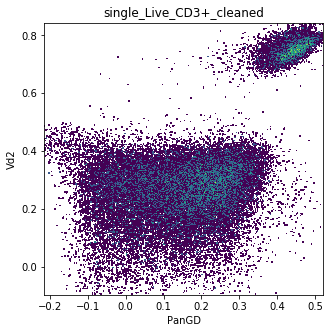

In [14]:
g.plotting.plot_population('single_Live_CD3+_cleaned', 'PanGD', 'Vd2')

In [10]:
g.population_size('single_Live_CD3+_cleaned')

50303

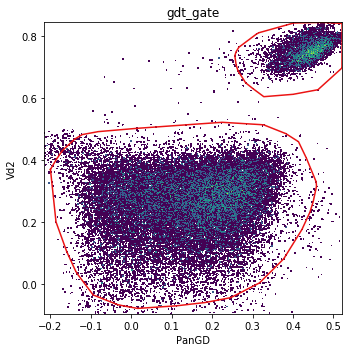

In [15]:
children = ChildPopulationCollection('cluster')
children.add_population('gdt', target=(0.4,0.8), weight=1)
children.add_population('non_gdt', target=(0.25,0.35), weight=1)
kwargs = dict(x='PanGD', y='Vd2', min_pop_size=100, frac=0.1)
g.create_gate(gate_name='gdt_gate', 
              parent='single_Live_CD3+_cleaned',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)
g.apply('gdt_gate')

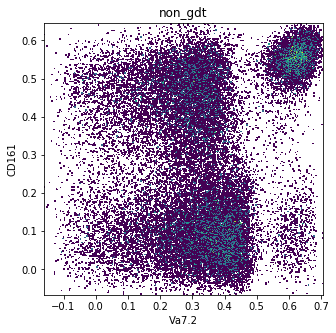

In [17]:
g.plotting.plot_population('non_gdt', 'Va7.2', 'CD161')

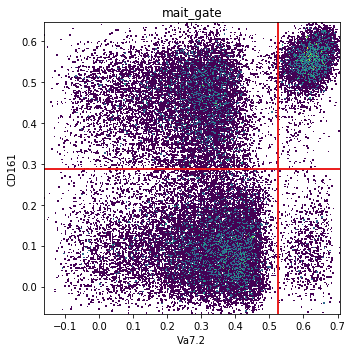

In [18]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('mait', definition='++')
children.add_population('classic', definition=['-+', '+-', '--'])
kwargs = dict(x='Va7.2', y='CD161', kde_bw=0.05, low_memory=True, peak_threshold=0.05)
g.create_gate(gate_name='mait_gate', 
              parent='non_gdt',
              class_='DensityThreshold',
              method='gate_2d',
              child_populations=children, 
              kwargs=kwargs)
g.apply('mait_gate')

In [19]:
g.print_population_tree()

root
├── cells
│   ├── CD3+
│   │   ├── dead
│   │   └── live
│   │       ├── singlets1
│   │       │   ├── single_Live_CD3+
│   │       │   │   └── single_Live_CD3+_cleaned
│   │       │   │       ├── gdt
│   │       │   │       └── non_gdt
│   │       │   │           ├── mait
│   │       │   │           └── classic
│   │       │   └── doublets2
│   │       └── doublets1
│   └── CD3-
└── debris


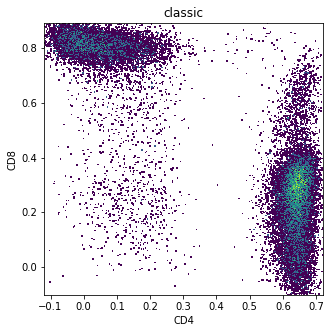

In [20]:
g.plotting.plot_population('classic', 'CD4', 'CD8')

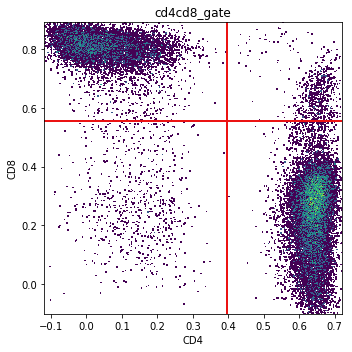

In [21]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('CD4+CD8-', definition='+-')
children.add_population('CD4-CD8-', definition='--')
children.add_population('CD4+CD8+', definition='++')
children.add_population('CD4-CD8+', definition='-+')
kwargs = dict(x='CD4', y='CD8', kde_bw=0.05, low_memory=True, peak_threshold=0.05)
g.create_gate(gate_name='cd4cd8_gate', 
              parent='classic',
              class_='DensityThreshold',
              method='gate_2d',
              child_populations=children, 
              kwargs=kwargs)
g.apply('cd4cd8_gate')

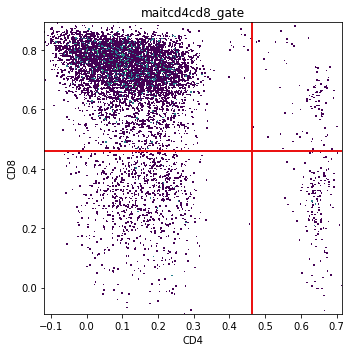

In [22]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('mait+CD4+CD8-', definition='+-')
children.add_population('mait+CD4-CD8-', definition='--')
children.add_population('mait+CD4+CD8+', definition='++')
children.add_population('mait+CD4-CD8+', definition='-+')
kwargs = dict(x='CD4', y='CD8', kde_bw=0.05, low_memory=True, peak_threshold=0.05)
g.create_gate(gate_name='maitcd4cd8_gate', 
              parent='mait',
              class_='DensityThreshold',
              method='gate_2d',
              child_populations=children, 
              kwargs=kwargs)
g.apply('maitcd4cd8_gate')

In [23]:
g.print_population_tree()

root
├── cells
│   ├── CD3+
│   │   ├── dead
│   │   └── live
│   │       ├── singlets1
│   │       │   ├── single_Live_CD3+
│   │       │   │   └── single_Live_CD3+_cleaned
│   │       │   │       ├── gdt
│   │       │   │       └── non_gdt
│   │       │   │           ├── mait
│   │       │   │           │   ├── mait+CD4+CD8-
│   │       │   │           │   ├── mait+CD4-CD8-
│   │       │   │           │   ├── mait+CD4+CD8+
│   │       │   │           │   └── mait+CD4-CD8+
│   │       │   │           └── classic
│   │       │   │               ├── CD4+CD8-
│   │       │   │               ├── CD4-CD8-
│   │       │   │               ├── CD4+CD8+
│   │       │   │               └── CD4-CD8+
│   │       │   └── doublets2
│   │       └── doublets1
│   └── CD3-
└── debris


In [24]:
g.save(overwrite=True)

Saved successfully!


True

In [25]:
g.save_new_template('Major_T_Populations_Cleaned')

No existing template named Major_T_Populations_Cleaned, creating new template


True

In [36]:
g = Template(pdtexp, 'Global_Uniform_Sample', include_controls=False)

In [37]:
g.load_template('Major_T_Populations_Cleaned')

True

In [38]:
g.population_size('single_Live_CD3+_cleaned')*0.05

16553.0

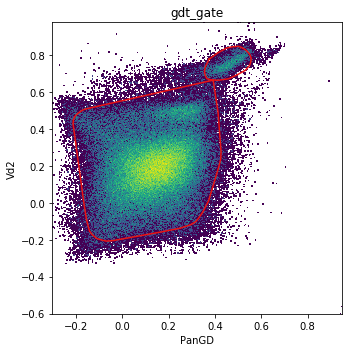

In [40]:
g.apply('gdt_gate', min_pop_size=200, frac=0.05)

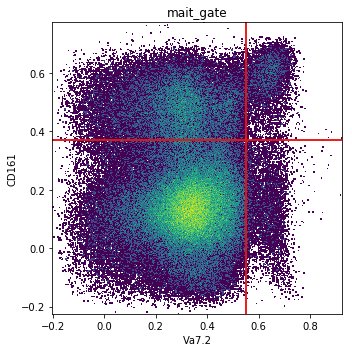

In [41]:
g.apply('mait_gate')

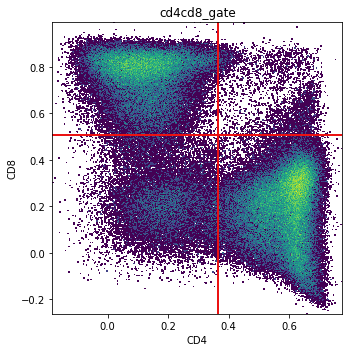

In [42]:
g.apply('cd4cd8_gate')

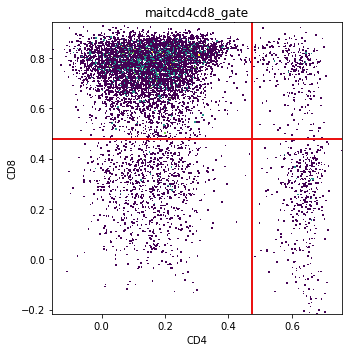

In [43]:
g.apply('maitcd4cd8_gate')

In [44]:
g.save(overwrite=True)

Saved successfully!


True

<h3>Label training data: PBMC T Panel</h3>

In [65]:
g = Template(pbtexp, '305-02_pbmc_t', include_controls=False)

In [66]:
g.remove_gate('gdt_gate')

(['mait_gate', 'cd4cd8_gate', 'maitcd4cd8_gate', 'gdt_gate'],
 ['gdt',
  'gdt',
  'non_gdt',
  'mait',
  'mait+CD4+CD8-',
  'mait+CD4-CD8-',
  'mait+CD4+CD8+',
  'mait+CD4-CD8+',
  'classic',
  'CD4+CD8-',
  'CD4-CD8-',
  'CD4+CD8+',
  'CD4-CD8+',
  'non_gdt'])

In [67]:
g.load_template('Major_T_Populations_Cleaned')

True

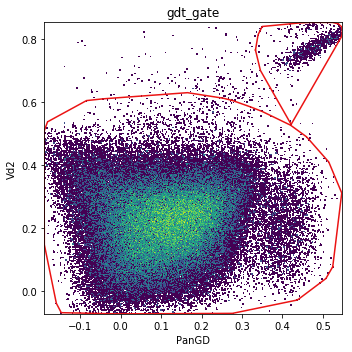

In [69]:
g.apply('gdt_gate', min_pop_size=50)

In [83]:
g.remove_population('mait')
g.remove_population('classic')

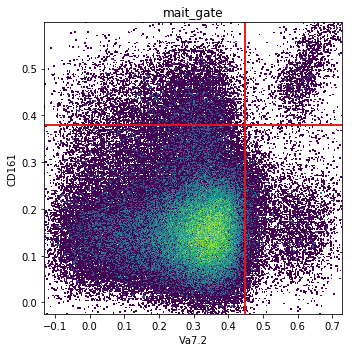

In [84]:
g.apply('mait_gate', kde_bw=0.01, peak_threshold=0.1)

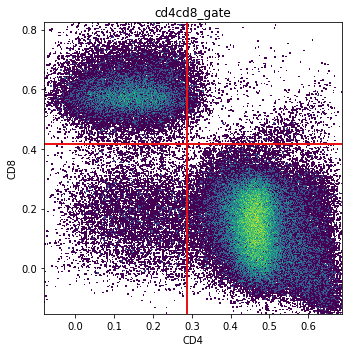

In [85]:
g.apply('cd4cd8_gate')

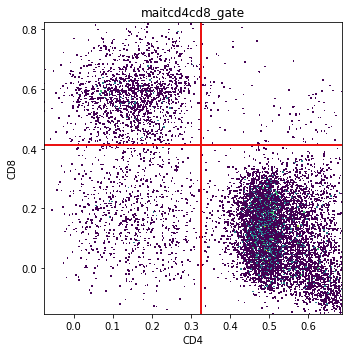

In [86]:
g.apply('maitcd4cd8_gate')

In [87]:
g.save(overwrite=True)

Saved successfully!


True

In [88]:
g = Template(pbtexp, 'Global_Uniform_Sample', include_controls=False)

In [89]:
g.load_template('Major_T_Populations_Cleaned')

True

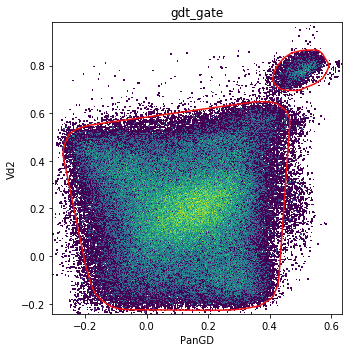

In [90]:
g.apply('gdt_gate')

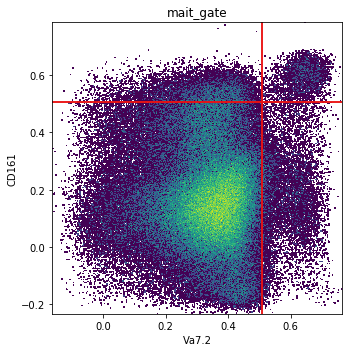

In [91]:
g.apply('mait_gate')

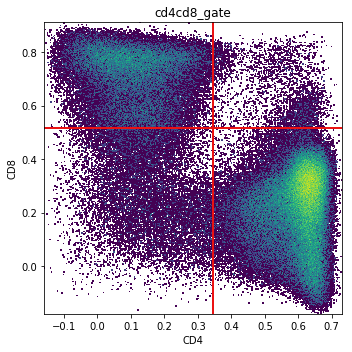

In [92]:
g.apply('cd4cd8_gate')

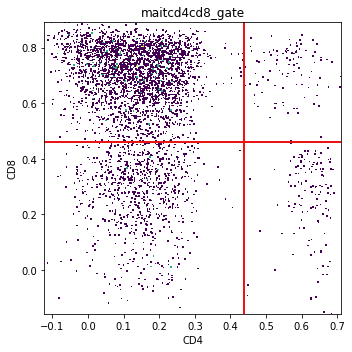

In [93]:
g.apply('maitcd4cd8_gate')

In [94]:
g.save(overwrite=True)

Saved successfully!


True

<h3>Label the training data: PDMC N Panel</h3>

In [4]:
g = Template(nexp, '294-03_pdmc_n', include_controls=False)

In [5]:
g.print_population_tree()

root
├── cells
│   ├── CD45+
│   │   ├── dead
│   │   └── Live_CD45+
│   │       ├── singlets1
│   │       │   ├── doublets2
│   │       │   └── Single_Live_CD45+
│   │       │       └── Single_Live_CD45+_cleaned
│   │       └── doublets1
│   └── CD45-
└── debris


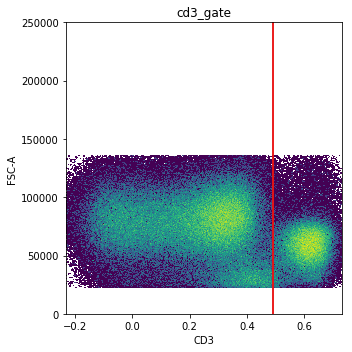

In [6]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('CD3+', definition='+')
children.add_population('CD3-', definition='-')
kwargs = dict(x='CD3', kde_bw=0.01, low_memory=True)
g.create_gate(gate_name='cd3_gate', 
              parent='Single_Live_CD45+_cleaned',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
g.apply('cd3_gate')

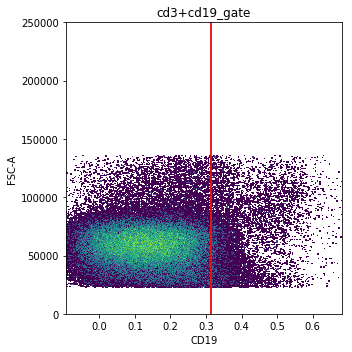

In [7]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('CD3+CD19-', definition='-')
children.add_population('CD3+CD19+', definition='+')
kwargs = dict(x='CD19', kde_bw=0.05, low_memory=True)
g.create_gate(gate_name='cd3+cd19_gate', 
              parent='CD3+',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
g.apply('cd3+cd19_gate')

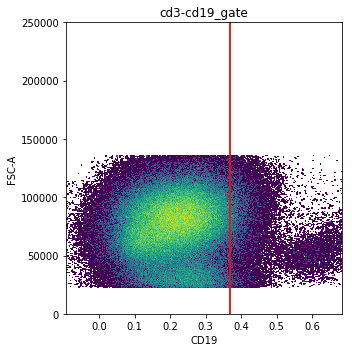

In [8]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('CD3-CD19-', definition='-')
children.add_population('CD3-CD19+', definition='+')
kwargs = dict(x='CD19', kde_bw=0.05, low_memory=True)
g.create_gate(gate_name='cd3-cd19_gate', 
              parent='CD3-',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
g.apply('cd3-cd19_gate')

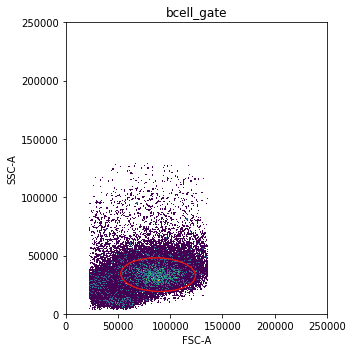

In [9]:
children = ChildPopulationCollection('geom')
children.add_population('B cells', definition='+')
children.add_population('not_B cells', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None, target=(80000, 25000))
g.create_gate(gate_name='bcell_gate', 
              parent='CD3-CD19+',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
g.apply('bcell_gate')

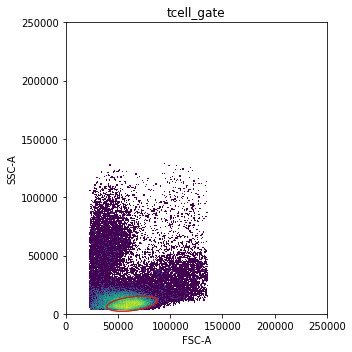

In [10]:
children = ChildPopulationCollection('geom')
children.add_population('T cells', definition='+')
children.add_population('not_T cells', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None, target=(60000, 10000))
g.create_gate(gate_name='tcell_gate', 
              parent='CD3+CD19-',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
g.apply('tcell_gate')

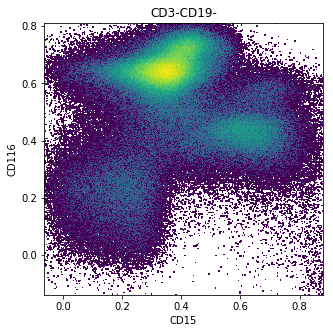

In [207]:
g.plotting.plot_population('CD3-CD19-', 'CD15', 'CD116')

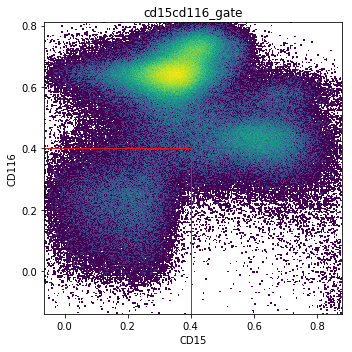

In [21]:
children = ChildPopulationCollection('geom')
children.add_population('CD15-CD116-', definition='+')
children.add_population('Myeloid', definition='-')

kwargs = dict(x='CD15', y='CD116', x_min=-0.2, x_max=0.4, y_min=-0.2, y_max=0.4)
g.create_gate(gate_name='cd15cd116_gate', 
              parent='CD3-CD19-',
              class_='Static',
              method='rect_gate',
              child_populations=children, 
              kwargs=kwargs)
g.apply('cd15cd116_gate')

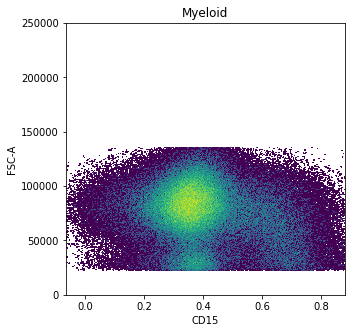

In [23]:
g.plotting.plot_population('Myeloid', 'CD15', 'FSC-A', transforms={'x': 'logicle', 'y': None})

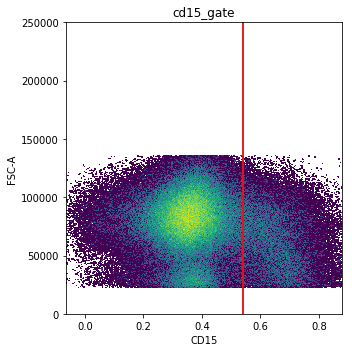

In [32]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('CD15+', definition='+')
children.add_population('CD15-', definition='-')

kwargs = dict(x='CD15', kde_bw=0.01, peak_threshold=0.01, low_memory=True)
g.create_gate(gate_name='cd15_gate', 
              parent='Myeloid',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
g.apply('cd15_gate')

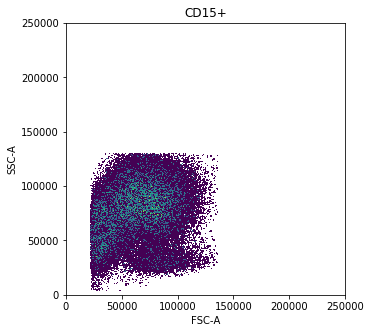

In [33]:
g.plotting.plot_population('CD15+', 'FSC-A', 'SSC-A', transforms={'x':None, 'y':None})

In [54]:
g.population_size('CD15+')*0.1

10678.800000000001

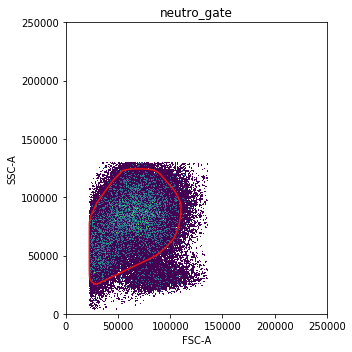

In [53]:
children = ChildPopulationCollection('cluster')
children.add_population('Neutrophils', target=(90000, 70000), weight=1)

kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None, min_pop_size=100, frac=0.1)
g.create_gate(gate_name='neutro_gate', 
              parent='CD15+',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)
g.apply('neutro_gate')

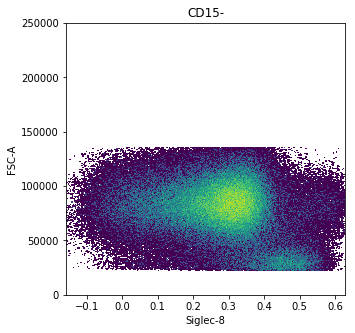

In [55]:
g.plotting.plot_population('CD15-', 'Siglec-8', 'FSC-A', transforms={'x':'logicle', 'y':None})

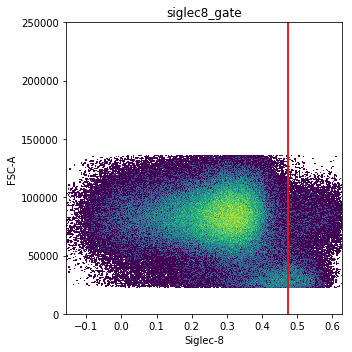

In [71]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('Siglec8+', definition='+')
children.add_population('Siglec8-', definition='-')

kwargs = dict(x='Siglec-8', kde_bw=0.1, low_memory=True, peak_threshold=0.01)
g.create_gate(gate_name='siglec8_gate', 
              parent='CD15-',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
g.apply('siglec8_gate')

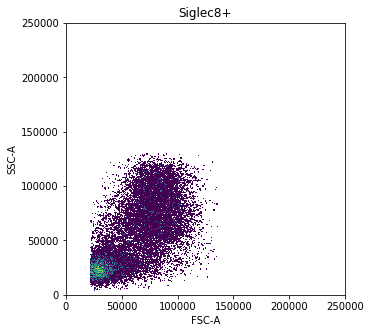

In [72]:
g.plotting.plot_population('Siglec8+', 'FSC-A', 'SSC-A', transforms={'x':None, 'y':None})

In [73]:
g.population_size('Siglec8+')

31338

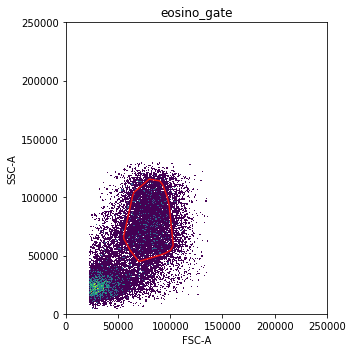

In [84]:
children = ChildPopulationCollection('cluster')
children.add_population('Eosinophils', target=(80000, 80000), weight=1)

kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None, min_pop_size=100, frac=0.5)
g.create_gate(gate_name='eosino_gate', 
              parent='Siglec8+',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)
g.apply('eosino_gate')

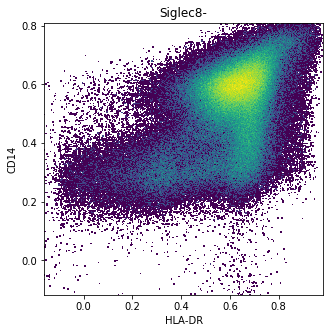

In [85]:
g.plotting.plot_population('Siglec8-', 'HLA-DR', 'CD14')

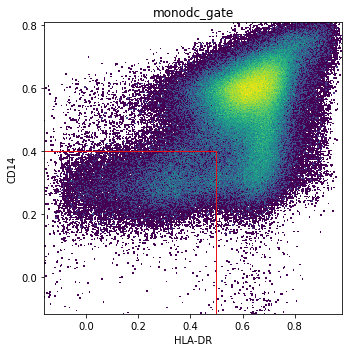

In [88]:
children = ChildPopulationCollection('geom')
children.add_population('MonoDCs', definition='-')
children.add_population('nonMonoDCs', definition='+')

kwargs = dict(x='HLA-DR', y='CD14', x_min=-0.2, x_max=0.5, y_min=-0.2, y_max=0.4)
g.create_gate(gate_name='monodc_gate', 
              parent='Siglec8-',
              class_='Static',
              method='rect_gate',
              child_populations=children, 
              kwargs=kwargs)
g.apply('monodc_gate')

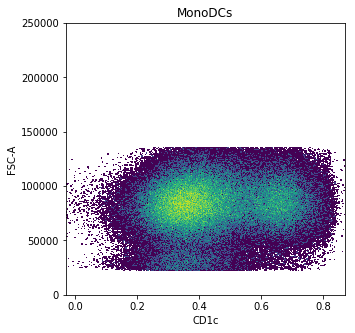

In [90]:
g.plotting.plot_population('MonoDCs', 'CD1c', 'FSC-A', transforms={'x':'logicle', 'y':None})

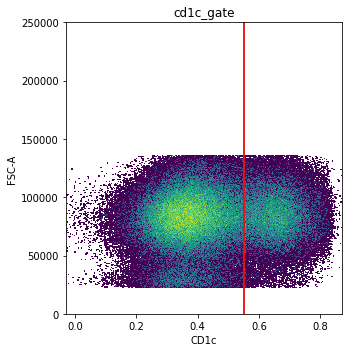

In [95]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('CD1c+', definition='+')
children.add_population('CD1c-', definition='-')

kwargs = dict(x='CD1c', kde_bw=0.01, low_memory=True, peak_threshold=0.01)
g.create_gate(gate_name='cd1c_gate', 
              parent='MonoDCs',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
g.apply('cd1c_gate')

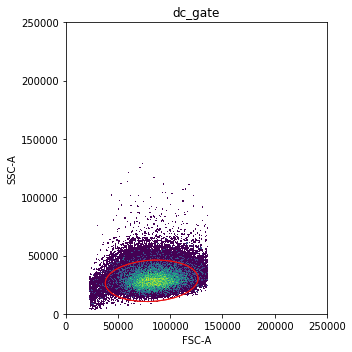

In [99]:
children = ChildPopulationCollection('geom')
children.add_population('DCs', definition='+')
children.add_population('non_DCs', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None, target=(80000, 25000), conf=0.999)
g.create_gate(gate_name='dc_gate', 
              parent='CD1c+',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
g.apply('dc_gate')

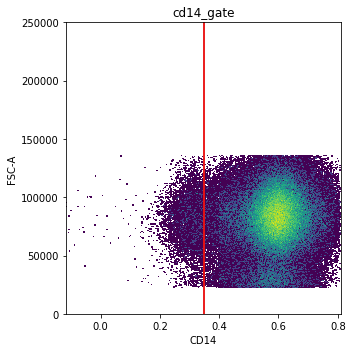

In [102]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('CD14+', definition='+')
children.add_population('CD14-', definition='-')

kwargs = dict(x='CD14', kde_bw=0.01, low_memory=True, peak_threshold=0.01)
g.create_gate(gate_name='cd14_gate', 
              parent='CD1c-',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
g.apply('cd14_gate')

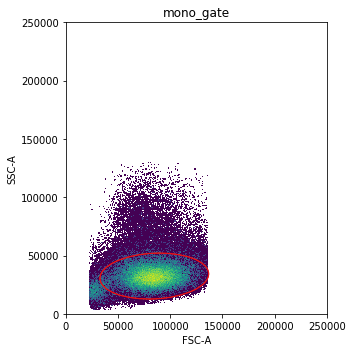

In [106]:
children = ChildPopulationCollection('geom')
children.add_population('Monocytes', definition='+')
children.add_population('non_Monocytes', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None, target=(80000, 25000), conf=0.99)
g.create_gate(gate_name='mono_gate', 
              parent='CD1c-',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
g.apply('mono_gate')

In [107]:
g.save(overwrite=True)

Saved successfully!


True

In [108]:
g.save_new_template('Major_N_Populations')

No existing template named Major_N_Populations, creating new template


True

In [109]:
g = Template(nexp, 'Global_Uniform_Sample', include_controls=False)

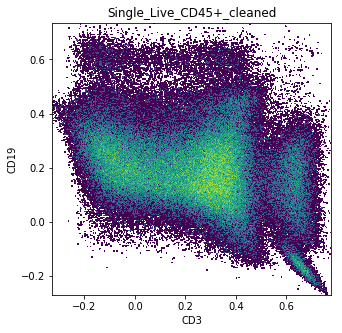

In [133]:
g.plotting.plot_population('Single_Live_CD45+_cleaned', 'CD3', 'CD19')

In [110]:
g.load_template('Major_N_Populations')

True

In [112]:
g.gates.keys()

dict_keys(['boundary', 'CD45_gate', 'live_gate', 'singlets1_gate', 'singlets2_gate', 'CD45_gate2', 'cd3_gate', 'cd3+cd19_gate', 'cd3-cd19_gate', 'bcell_gate', 'tcell_gate', 'cd15_gate', 'neutro_gate', 'siglec8_gate', 'eosino_gate', 'monodc_gate', 'cd1c_gate', 'dc_gate', 'cd14_gate', 'mono_gate'])

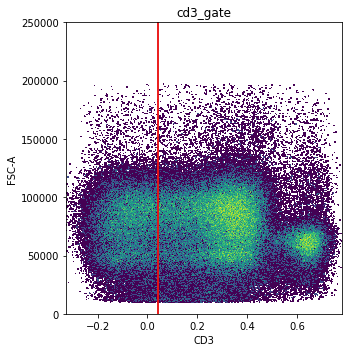

In [130]:
g.apply('cd3_gate', kde_bw=0.04)

In [129]:
g.populations.pop('CD3+')
g.populations.pop('CD3-')

Node('/Single_Live_CD45+_cleaned/CD3-', geom={'method': 'Quantile', 'threshold': 0.641779428539278, 'shape': 'threshold', 'x': 'CD3', 'y': None}, index=array([     0,      1,      2, ..., 359997, 359998, 359999]), population_name='CD3-', prop_of_parent=0.9485944444444444, prop_of_total=0.9485944444444444, warnings=[])